## Level 1 Requirement Flowdown

### L1-4 Global Fluxes (Global Mode)

> Carbon-I shall obtain column averaged mixing ratios with a standard error of ≤12 ppb CH4, ≤2.5 ppm CO2, and ≤10 ppb for CO once averaged to a 12 km × 12 km grid resolution for over 50% of such grid each month¹.  

¹: Averaged over 12 months.

---

Let's codify these numbers

In [58]:
using Pkg
Pkg.activate("../.."); # Actives the environment at the root of the project
# Using our Carbon-I and vSmartMOM packages (developed by our team)
using CarbonI, vSmartMOM, Printf
using CairoMakie, DelimitedFiles, Statistics, Interpolations, NCDatasets, InstrumentOperator, LinearAlgebra
using Unitful, UnitfulEquivalences
include(joinpath("../../src/Plots", "CI_colorsNew.jl"));
include(joinpath(dirname(pathof(CarbonI)), "readSun.jl"))
include(joinpath(dirname(pathof(CarbonI)), "Requirements", "common.jl"))
set_theme!(theme_ggplot2())


In [59]:
# Define numbers from L1 Requirements

# Global Mode (L1-4)
global_mode_ch4_error = 12.0            # in ppb
global_mode_co2_error = 2.5             # in ppm
global_mode_co_error = 10.0             # in ppb

global_mode_grid_resolution = [12e3, 12e3]  # in m
global_mode_coverage = 50.0             # in percentage
global_mode_gsd_req  = [400.0, 400.0]           # in m
global_mode_gsd_cbe  = [305.0, 345.0]   # in m


# Reference Background VMRs
background_vmr_ch4 = 1950.0  # in ppb
background_vmr_co2 = 410.0   # in ppm
background_vmr_n2o = 320.0   # in ppb

320.0

In [60]:
# Read cloud median statistics in 10S-10N from Yinon
cs = readdlm("../../data/CloudStatsCentralAmazonia.dat");
cf_interp = LinearInterpolation(cs[:,1], cs[:,2], extrapolation_bc=Line());
gsds = 30:10:1000;

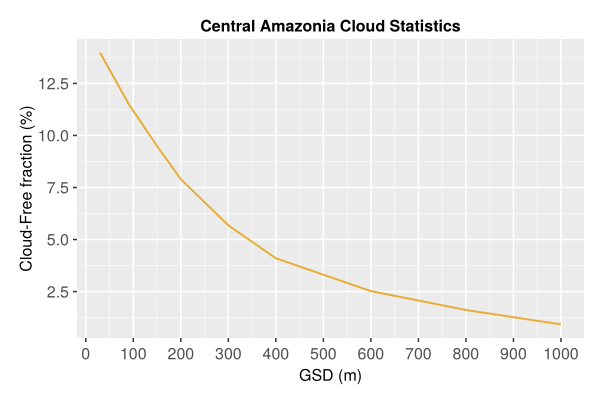

In [61]:
f = Figure(resolution=(600,400))
ax = Axis(f[1,1], xlabel="GSD (m)", ylabel="Cloud-Free fraction (%)", xticks = 0:100:1000, title="Central Amazonia Cloud Statistics")
lines!(ax, gsds, 100cf_interp.(gsds), color=CarbonI_colors[1], linewidth=2)
f

Now we can compute the potential number of footprints in the global grid, i.e.
$$
N_{max} = \frac{GSD_x \times GSD_y}{Grid_x \times Grid_y}
$$:

In [62]:
# Maximum number of global ground pixels in the 12km box
# Req.
N_max_global_req = prod(global_mode_grid_resolution)/prod(global_mode_gsd_req);
# At CBE
N_max_global_cbe = prod(global_mode_grid_resolution)/prod(global_mode_gsd_cbe);

And apply the conservative cloud statistics in the central Amazon (neglecting that we can tolerate higher sub-pixel clouds)

In [63]:
# Number of cloud-free global ground pixels in the 12km box
# Req.
N_eff_global_req = N_max_global_req * cf_interp(sqrt(prod(global_mode_gsd_req)));
# At CBE
N_eff_global_cbe = N_max_global_cbe * cf_interp(sqrt(prod(global_mode_gsd_cbe)));

We can now derive the requirement for $\sigma_{s}^{rel}$, as:
$$
\sigma_s^{rel} < \underbrace{\sigma_{agg}^{rel}}_{Required} \times \sqrt{N_{eff}}  
$$

In [64]:
sigma_rel_agg_global_req      =  min(global_mode_ch4_error/background_vmr_ch4 ,  global_mode_co2_error/background_vmr_co2)  # This should effectively be the same relative error for CO2 and CH4
sigma_rel_SingleSounding_req  =  sigma_rel_agg_global_req * sqrt(N_eff_global_req)  
sigma_rel_SingleSounding_cbe  =  sigma_rel_agg_global_req * sqrt(N_eff_global_cbe)
@printf("Required Single Measurement Precision for N₂O in percent for req. GSD : %.3g\n", 100*sigma_rel_SingleSounding_req)
@printf("Required Single Measurement Precision for N₂O in percent for CBE specs: %.3g\n", 100*sigma_rel_SingleSounding_cbe)

Just to show that the CH4 or CO2 precisions hardly matter for the relative errors:
$$
\sigma_{\mathrm{rel}}(R)
\;=\;\sqrt{\;\sigma_{\mathrm{rel}}^2\!\bigl(\Omega_{\mathrm{CH_4,CO_2}}\bigr)
+\;\sigma_{\mathrm{rel}}^2\!\bigl(\Omega_{\mathrm{N_2O}}\bigr)\,},
$$

In [65]:
σ_n2o = 3.5 # Error in %
σ_ghg = 0.5 # Error in % (CO2 and CH4, even smaller than that)
σ_rel = sqrt(σ_n2o^2 + σ_ghg^2)
@printf("Error Enhancement factor if also considering GHG noise: %.3g\n", σ_rel / σ_n2o)
ampl = σ_rel / σ_n2o

1.0101525445522108

In [66]:
# Now we have to set up the fit:
Δwl = 0.01
wl = 2000:Δwl:2400
@show wlSol
clima_alb = readdlm(CarbonI.albedo_file,',', skipstart=1)
#soil = CubicSplineInterpolation(450:2500,r[:,140], extrapolation_bc=Interpolations.Flat());
tropical_forest_albedo = CubicSplineInterpolation(300:2400,clima_alb[:,2]/1.16, extrapolation_bc=Interpolations.Flat());
sol  = CubicSplineInterpolation(range(wlSol[1],wlSol[end], length=length(wlSol)),solar_irr, extrapolation_bc=Interpolations.Flat());
solarIrr = sol.(wl);
refl     = tropical_forest_albedo.(wl);

Now we have to show what instrument specs we require to get to that precision. 
--> We could bypass SNR and just use our tropical reference scene (with spectrally varying albedo) and compute sigma as function of total system efficiency (i.e. optical throughput and Qe)

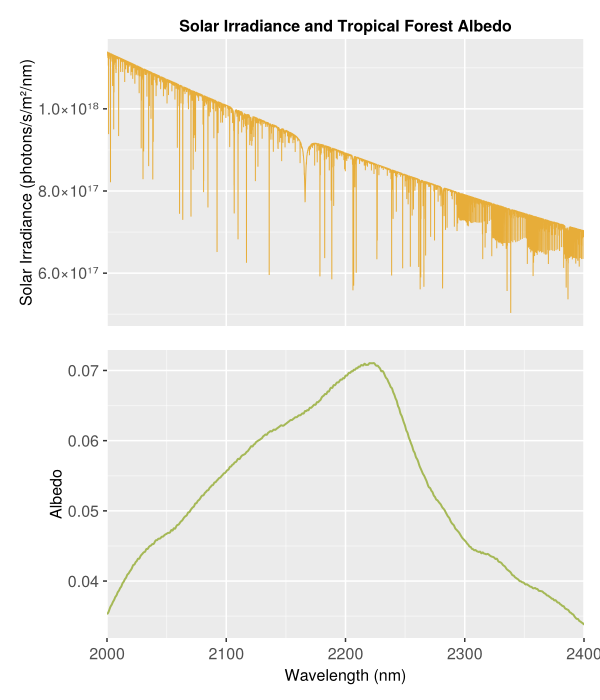

In [67]:
f = Figure(resolution=(600,700))
ax = Axis(f[1,1], xlabel="Wavelength (nm)", ylabel="Solar Irradiance (photons/s/m²/nm)",  title="Solar Irradiance and Tropical Forest Albedo")
lines!(ax, wl,  solarIrr/1000 .* wl * 1e-9/ (6.626e-34 * 2.998e8), color=CarbonI_colors[1], linewidth=1)
ax2 = Axis(f[2,1], xlabel="Wavelength (nm)", ylabel="Albedo")
lines!(ax2, wl, tropical_forest_albedo.(wl), color=CarbonI_colors[2], linewidth=2)
xlims!(ax, 2000, 2400)
xlims!(ax2, 2000, 2400)
hidexdecorations!(ax, grid=false)
f

In [68]:
# Load stressing scenario (tropical forest)
scenario = CarbonI.stressing_scenario()

req_specs = CarbonI.build_instrument("Requirement") 
cbe_specs = CarbonI.build_instrument("CBE") 



# Create required Instrument model 
ins_req = InstrumentOperator.createGratingNoiseModel(req_specs.ET, req_specs.Pitch, 
		req_specs.FPA_quantum_efficiency, req_specs.bench_efficiency, 
		req_specs.Fnumber, 2*req_specs.SSI, 
		(req_specs.readout_noise), req_specs.dark_current); 

# Create required Instrument model
ins_cbe = InstrumentOperator.createGratingNoiseModel(cbe_specs.ET, cbe_specs.Pitch, 
		cbe_specs.FPA_quantum_efficiency, cbe_specs.bench_efficiency, 
		cbe_specs.Fnumber, 2*cbe_specs.SSI, 
		(cbe_specs.readout_noise), cbe_specs.dark_current); 

soil_req, x_req, solarIrr_req, σ_matrix_req, profile_req, h_req, Sₐ_req = setup_data(scenario, req_specs)
soil_cbe, x_cbe, solarIrr_cbe, σ_matrix_cbe, profile_cbe, h_cbe, Sₐ_cbe = setup_data(scenario, cbe_specs);
refl_req   = soil_req(req_specs.modelling_wl);# * scenario.broadband_albedo/mean_base_albedo;
refl_cbe   = soil_cbe(cbe_specs.modelling_wl);# * scenario.broadband_albedo/mean_base_albedo

In [69]:
error_req, F_req = calc_rel_error(req_specs, x_req, solarIrr_req, refl_req, scenario.sza, σ_matrix_req, profile_req, h_req, ins_req, Sₐ_req, return_F=true) 
error_cbe, F_cbe = calc_rel_error(cbe_specs, x_cbe, solarIrr_cbe, refl_cbe, scenario.sza, σ_matrix_cbe, profile_cbe, h_cbe, ins_cbe, Sₐ_cbe, return_F=true) 

(Dict{Any, Any}("ch4" => 18.295676564741274, "h2o" => 48439.29613660661, "co" => 88.77945329436233, "n2o" => 32.00094210829379, "hdo" => 432124.76461736416, "c2h6" => 43.84233130814615, "co2" => 3300.1575324995606, "co213" => 27514.067238861102), [1.1834873239533168, 1.1829423629307556, 1.1225193403393685, 0.9741420802712132, 0.9367338185447047, 0.8289887663658512, 0.6092126614467663, 0.7417731283431376, 1.0069984488486243, 1.0344269972397144  …  0.537853357387494, 0.4550211833336741, 0.3040500721443183, 0.259470205991848, 0.2376651507076862, 0.22656829125504188, 0.2158129747023853, 0.10205207236195064, 0.06913346160409753, 0.17299513964369634])

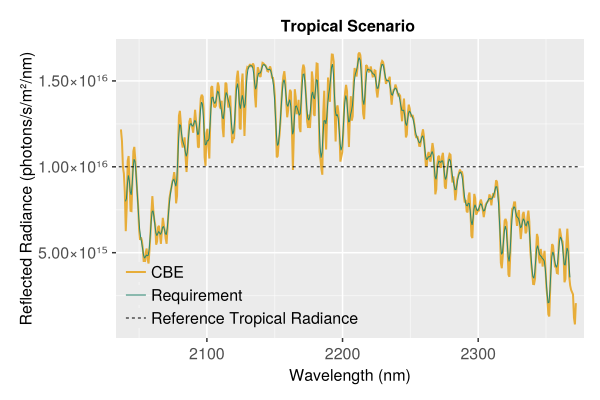

In [70]:
from_w_to_photons = 5.03e12
refRadiance = 1.0e16 # in photons/s/m²/nm

f = Figure(resolution=(600,400))
ax = Axis(f[1,1], xlabel="Wavelength (nm)", ylabel="Reflected Radiance (photons/s/m²/nm)",  title="Tropical Scenario ")
lines!(ax, cbe_specs.instrument_wl,F_cbe * from_w_to_photons .* cbe_specs.instrument_wl, color=CarbonI_colors[1], linewidth=2, label="CBE")
lines!(ax, req_specs.instrument_wl,F_req * from_w_to_photons .* req_specs.instrument_wl, color=CarbonI_colors[3], linewidth=1, label="Requirement")
lines!(ax, [2035,2375], [refRadiance,refRadiance], color=:black, linestyle=:dash, linewidth=1, label="Reference Tropical Radiance")
xlims!(ax, 2033, 2378)
axislegend(ax,position = :lb)
f

In [71]:
# Now vary total efficiency at two different readout noise levels:

TotalEfficiencies = 0.3:0.05:1.0
n2o_errors_100 = zeros(length(TotalEfficiencies))
n2o_errors_120 = zeros(length(TotalEfficiencies))
for (i,efficiency) in enumerate(TotalEfficiencies)
    # Create instrument Specs here:
    # (here we need to use 57ms integration time for req. as we count 400m pixels along track dimension)
    ins_req_100 = InstrumentOperator.createGratingNoiseModel(57.0u"ms", req_specs.Pitch, 1.0, efficiency, req_specs.Fnumber, 2*req_specs.SSI, (100.0), req_specs.dark_current); 
    ins_req_120 = InstrumentOperator.createGratingNoiseModel(57.0u"ms", req_specs.Pitch, 1.0, efficiency, req_specs.Fnumber, 2*req_specs.SSI, (120.0), req_specs.dark_current); 
    # Create an error for 100 and 120e- for the respective efficiency
    error_varied_100 = calc_rel_error(req_specs, x_req, solarIrr_req, refl_req, scenario.sza, σ_matrix_req, profile_req, h_req, ins_req_100, Sₐ_req) 
    error_varied_120 = calc_rel_error(req_specs, x_req, solarIrr_req, refl_req, scenario.sza, σ_matrix_req, profile_req, h_req, ins_req_120, Sₐ_req) 
    # Store Data
    n2o_errors_100[i] = error_varied_100["n2o"]/background_vmr_n2o/sqrt(req_specs.coadd_rate)
    n2o_errors_120[i] = error_varied_120["n2o"]/background_vmr_n2o/sqrt(req_specs.coadd_rate) 
end

In [72]:
# Create an interpolation function to get the required optical efficiency for a given readout noise and proxy error for N2O
# Annoying as it requires ascending order in the x-axis
efficiency_100 = LinearInterpolation(reverse(100(n2o_errors_100)), reverse(TotalEfficiencies), extrapolation_bc=Line());
efficiency_120 = LinearInterpolation(reverse(100(n2o_errors_120)), reverse(TotalEfficiencies), extrapolation_bc=Line());

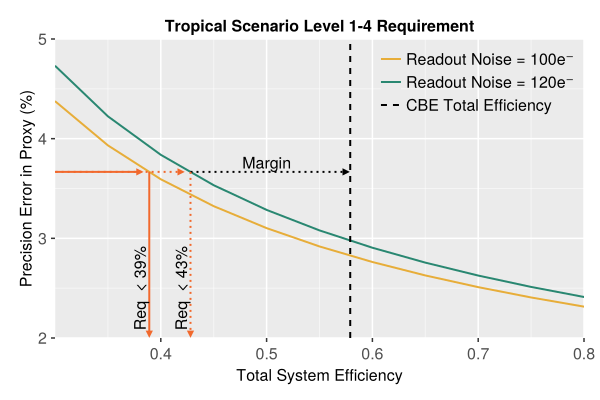

In [ ]:
f = Figure(resolution=(600,400))
ax = Axis(f[1,1], xlabel="Total System Efficiency", ylabel="Precision Error in Proxy (%)",  title="Tropical Scenario Level 1-4 Requirement")
lines!(ax, TotalEfficiencies, n2o_errors_100*100, color=CarbonI_colors[1], linewidth=2, label="Readout Noise = 100e⁻")
lines!(ax, TotalEfficiencies, n2o_errors_120*100, color=CarbonI_colors[3], linewidth=2, label="Readout Noise = 120e⁻")

req_error        = 100*sigma_rel_SingleSounding_req /ampl
req_error_cbeGSD = 100*sigma_rel_SingleSounding_cbe /ampl
req_eff = efficiency_100(req_error)
req_eff_120 = efficiency_120(req_error)
eff_cbe = cbe_specs.bench_efficiency * cbe_specs.FPA_quantum_efficiency

arrows!(ax, [0.0,],[req_error,],[req_eff-0.01,],[0,],arrowsize = 10, linewidth=2,color = CarbonI_colors[5])
arrows!(ax, [0.0,],[req_error,],[req_eff_120-0.01,],[0,],arrowsize = 10, linewidth=2,linestyle=:dot, color = CarbonI_colors[5])
arrows!(ax, [req_eff_120,],[req_error,],[eff_cbe-req_eff_120-0.005,],[0,],arrowsize = 10, linewidth=2,linestyle=:dot, color = :black)
text!(ax, "Margin", position = (0.5, req_error),  align = (:center, :bottom), color = :black)
arrows!(ax, [req_eff,],[req_error,],[0,],[-req_error+2.05,],arrowsize = 10, linewidth=2,color = CarbonI_colors[5])
text!(ax, "Req: > $(round(Int, 100req_eff))%", position = (req_eff, 2.5),
    align = (:center, :bottom), color = :black, rotation=π/2)

arrows!(ax, [req_eff_120,],[req_error,],[0,],[-req_error+2.05,],arrowsize = 10, linewidth=2,linestyle=:dot, color = CarbonI_colors[5])
text!(ax, "Req: > $(round(Int, 100req_eff_120))%", position = (req_eff_120, 2.5),
    align = (:center, :bottom), color = :black, rotation=π/2)
lines!(ax, [eff_cbe,eff_cbe], [2,6], color=:black, linestyle=:dash, linewidth=2, label="CBE Total Efficiency")
#arrows!(ax2, [req_percent_ch4,],[req_flux_ch4,],[-req_percent_ch4+1,],[0,],arrowsize = 10, linewidth=2,color = CarbonI_colors[5])
#text!(ax2, "Req. >90%", position = (req_percent_ch4, 25),
#      align = (:center, :bottom), color = :black, rotation=π/2)

axislegend(ax,position = :rt)
xlims!(ax,0.3,0.8)
ylims!(ax,2,5)
f

In [75]:
ins_req_forSNR = InstrumentOperator.createGratingNoiseModel(44.0u"ms", req_specs.Pitch, 1.0, req_eff_120, req_specs.Fnumber, 2*req_specs.SSI, (120.0), req_specs.dark_current);
ins_cbe_forSNR = InstrumentOperator.createGratingNoiseModel(44.0u"ms", cbe_specs.Pitch, 1.0, eff_cbe, cbe_specs.Fnumber, 2*cbe_specs.SSI, (100.0), cbe_specs.dark_current);
# Use reference Wavelength here (just for conversion)
ref_wl = 2250;


refRadiance_mw = refRadiance / from_w_to_photons / ref_wl
nesr_req_forSNR = InstrumentOperator.noise_equivalent_radiance(ins_req_forSNR, (ref_wl)u"nm", (refRadiance_mw)u"mW/m^2/nm/sr");
nesr_cbe_forSNR = InstrumentOperator.noise_equivalent_radiance(ins_cbe_forSNR, (ref_wl)u"nm", (refRadiance_mw)u"mW/m^2/nm/sr");

@show refRadiance_mw/(nesr_req_forSNR[1]./1u"mW/m^2/nm/sr"), refRadiance_mw/(nesr_cbe_forSNR[1]./1u"mW/m^2/nm/sr")


(81.88026272920996, 110.23506273436915)